# Day 6: Model Evaluation & Metrics
## Week 4: Machine Learning Foundations

---

### 🎯 Learning Objectives
- Master regression metrics (MSE, MAE, R², MAPE)
- Understand classification metrics deeply
- Learn trading-specific evaluation
- Implement backtesting metrics

| **Profit Factor** | Gross profit / Gross loss | Win/loss ratio |

---| **Hit Rate** | % profitable trades | Prediction accuracy |

| **Max Drawdown** | Peak to trough | Worst case loss |

### 📈 Why Proper Evaluation Matters| **Sharpe Ratio** | Mean/Std of returns | Risk-adjusted return |

|--------|---------|------------------|

**Wrong metric = Wrong model = Lost money**| Metric | Formula | What It Measures |



Different metrics answer different questions:### 🎯 Trading-Specific Metrics



| Metric Type | Question Answered || **Sharpe** | Is the strategy worth the risk? |

|-------------|------------------|| **Accuracy** | What % of predictions are correct? |

| **MSE/RMSE** | How far off are predictions on average? || **R²** | How much variance is explained? |

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve, auc, average_precision_score

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)

prices = data['Close'].dropna()
print(f"✅ Data loaded: {prices.shape[0]} days")

returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1254 days


## 1. Regression Metrics

With leverage and many trades, small edge compounds.

### 🎯 Metrics for Return Prediction

**R² of 2% can still make money!**

| Metric | Formula | Trading Interpretation |

|--------|---------|------------------------|### Key Insight

| **MSE** | Mean((y - ŷ)²) | Penalizes large errors heavily |

| **RMSE** | √MSE | Same units as returns || < 0% | Worse than mean | Model is harmful |

| **MAE** | Mean(\|y - ŷ\|) | Average error magnitude || 0-2% | Typical | Still potentially profitable |

| **R²** | 1 - SS_res/SS_tot | % variance explained || 2-5% | Very good | Top quant funds achieve this |

| **IC** | Corr(y, ŷ) | Information coefficient || > 10% | Suspiciously high | Likely overfit or data leakage |

|----|----------------|---------------|

### What's a "Good" R² in Finance?| R² | Interpretation | Reality Check |


In [2]:
# Create simple prediction setup
print("=" * 60)
print("REGRESSION METRICS")
print("=" * 60)

# Feature matrix
def create_features(returns, target_col):
    X = pd.DataFrame(index=returns.index)
    for lag in range(1, 6):
        X[f'lag_{lag}'] = returns[target_col].shift(lag)
    for col in returns.columns:
        if col != target_col:
            X[f'{col}_lag1'] = returns[col].shift(1)
    return X.dropna()

X = create_features(returns, 'MSFT')
y = returns['MSFT'].loc[X.index]

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Fit model
model = Ridge(alpha=1.0)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)

# Calculate metrics
print("\n📊 Regression Metrics:")
print(f"  MSE  (Mean Squared Error):     {mean_squared_error(y_test, y_pred):.6f}")
print(f"  RMSE (Root Mean Squared Error): {np.sqrt(mean_squared_error(y_test, y_pred)):.6f}")
print(f"  MAE  (Mean Absolute Error):    {mean_absolute_error(y_test, y_pred):.6f}")
print(f"  R²   (Coefficient of Determination): {r2_score(y_test, y_pred):.6f}")

# Compare to naive benchmark
naive_pred = np.full_like(y_test, y_train.mean())  # Predict mean
print(f"\n📊 Naive Benchmark (predict mean):")
print(f"  MSE:  {mean_squared_error(y_test, naive_pred):.6f}")
print(f"  R²:   {r2_score(y_test, naive_pred):.6f}")

REGRESSION METRICS

📊 Regression Metrics:
  MSE  (Mean Squared Error):     0.000228
  RMSE (Root Mean Squared Error): 0.015097
  MAE  (Mean Absolute Error):    0.010186
  R²   (Coefficient of Determination): 0.008998

📊 Naive Benchmark (predict mean):
  MSE:  0.000230
  R²:   -0.001932


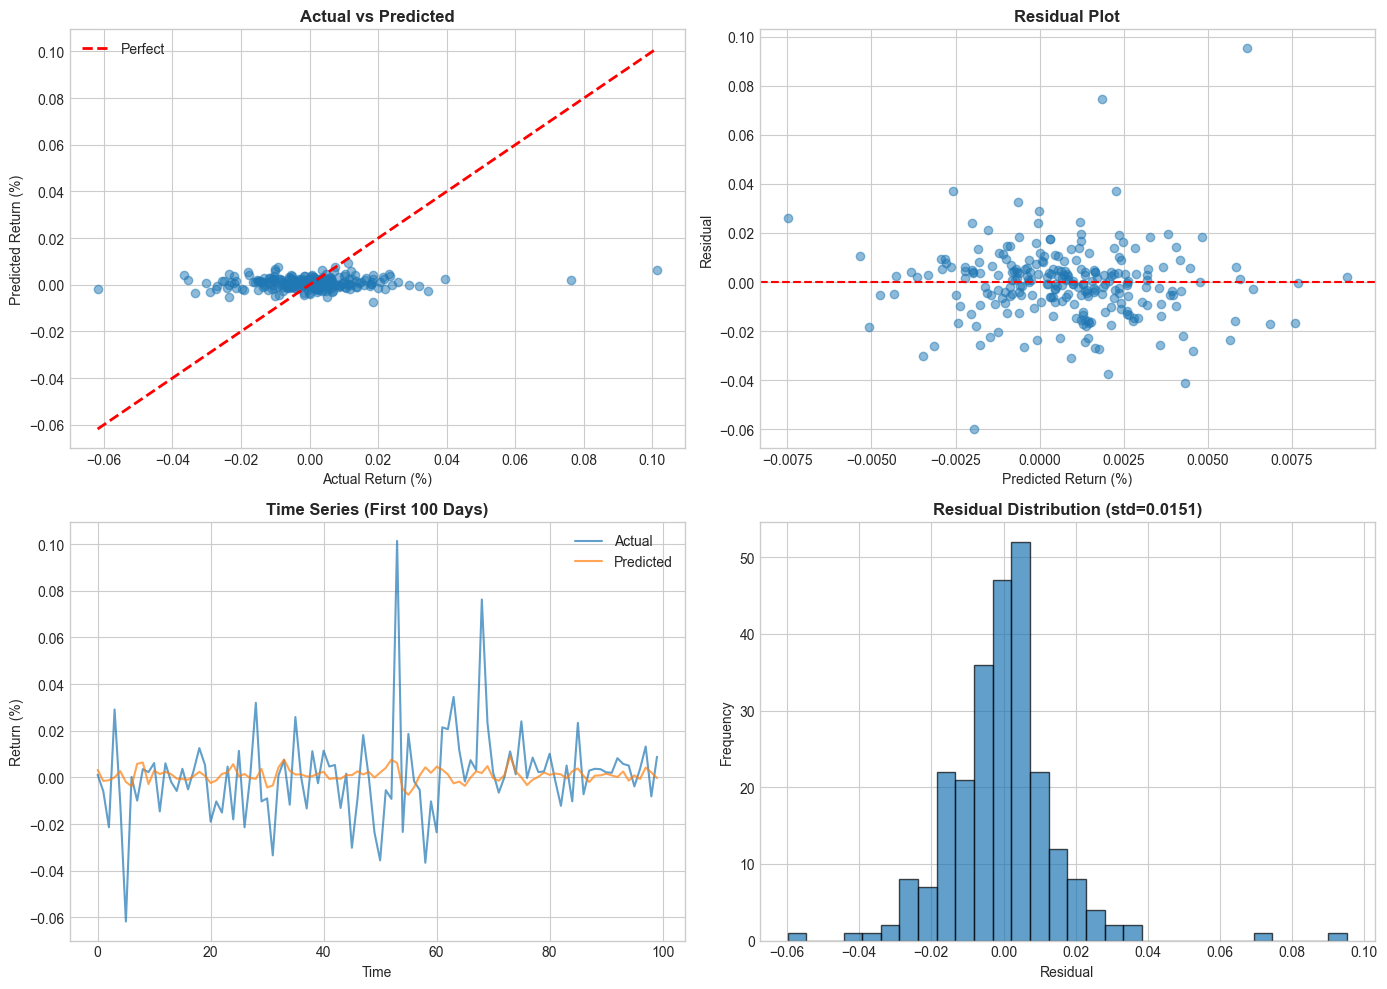

In [3]:
# Visualize regression predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Actual vs predicted
axes[0, 0].scatter(y_test, y_pred, alpha=0.5)
min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
axes[0, 0].set_xlabel('Actual Return (%)')
axes[0, 0].set_ylabel('Predicted Return (%)')
axes[0, 0].set_title('Actual vs Predicted', fontweight='bold')
axes[0, 0].legend()

# Residuals
residuals = y_test.values - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Return (%)')
axes[0, 1].set_ylabel('Residual')
axes[0, 1].set_title('Residual Plot', fontweight='bold')

# Time series
axes[1, 0].plot(y_test.values[:100], label='Actual', alpha=0.7)
axes[1, 0].plot(y_pred[:100], label='Predicted', alpha=0.7)
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Return (%)')
axes[1, 0].set_title('Time Series (First 100 Days)', fontweight='bold')
axes[1, 0].legend()

# Residual distribution
axes[1, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Residual')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Residual Distribution (std={residuals.std():.4f})', fontweight='bold')

plt.tight_layout()
plt.show()

## 2. Classification Metrics Deep Dive

| Balanced | F1 | Trade-off between both |

### 🎯 The Confusion Matrix for Trading| Market timing | Recall | Catch all the up days |

| Long only | Precision | Avoid false positives (losses) |

|  | Predicted Up | Predicted Down ||----------|----------|-----|

|--|--------------|----------------|| Strategy | Focus On | Why |

| **Actual Up** | True Positive (profit on long) | False Negative (missed opportunity) |

| **Actual Down** | False Positive (loss on long) | True Negative (avoided loss) |### Which Metric Matters Most?



### Key Metrics Explained| **F1** | 2×Prec×Rec/(Prec+Rec) | Balance of precision and recall |

| **Recall** | TP/(TP+FN) | Of up days, how many did you catch? |

| Metric | Formula | Trading Meaning || **Precision** | TP/(TP+FP) | When you go long, how often right? |

|--------|---------|----------------|| **Accuracy** | (TP+TN)/(All) | Overall hit rate |

In [4]:
# Classification setup
print("=" * 60)
print("CLASSIFICATION METRICS DEEP DIVE")
print("=" * 60)

# Create binary target
y_binary = (returns['MSFT'] > 0).astype(int).loc[X.index]

# Split
y_train_bin = y_binary.iloc[:split]
y_test_bin = y_binary.iloc[split:]

# Train classifier
clf = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
clf.fit(X_train_s, y_train_bin)
y_pred_bin = clf.predict(X_test_s)
y_prob = clf.predict_proba(X_test_s)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test_bin, y_pred_bin)
tn, fp, fn, tp = cm.ravel()

print("\n📊 Confusion Matrix:")
print(f"              Predicted")
print(f"              Down   Up")
print(f"  Actual Down  {tn:4d}  {fp:4d}")
print(f"  Actual Up    {fn:4d}  {tp:4d}")

print("\n📊 Derived Metrics:")
print(f"  Accuracy:     {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"  Precision:    {tp / (tp + fp):.4f}  (of predicted Up, how many correct?)")
print(f"  Recall:       {tp / (tp + fn):.4f}  (of actual Up, how many detected?)")
print(f"  Specificity:  {tn / (tn + fp):.4f}  (of actual Down, how many correct?)")
print(f"  F1 Score:     {2*tp / (2*tp + fp + fn):.4f}")
print(f"  AUC-ROC:      {roc_auc_score(y_test_bin, y_prob):.4f}")

CLASSIFICATION METRICS DEEP DIVE

📊 Confusion Matrix:
              Predicted
              Down   Up
  Actual Down    44    73
  Actual Up      48    85

📊 Derived Metrics:
  Accuracy:     0.5160
  Precision:    0.5380  (of predicted Up, how many correct?)
  Recall:       0.6391  (of actual Up, how many detected?)
  Specificity:  0.3761  (of actual Down, how many correct?)
  F1 Score:     0.5842
  AUC-ROC:      0.5059


PRECISION-RECALL ANALYSIS


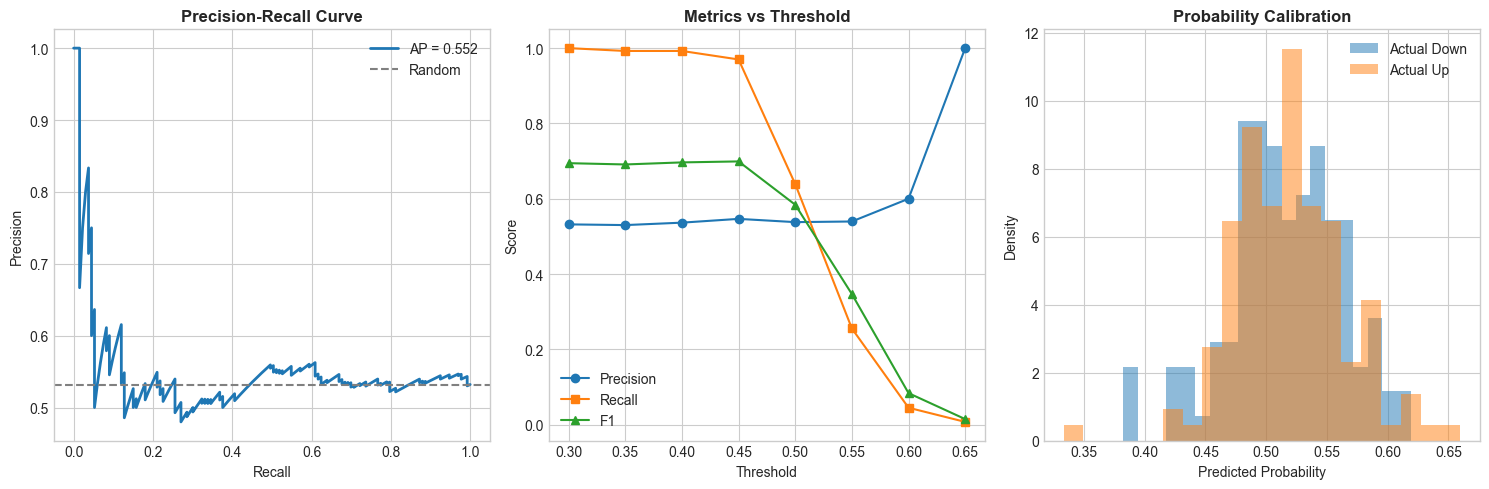


Threshold Analysis:
 Threshold  Precision   Recall       F1
      0.30   0.532000 1.000000 0.694517
      0.35   0.530120 0.992481 0.691099
      0.40   0.536585 0.992481 0.696570
      0.45   0.546610 0.969925 0.699187
      0.50   0.537975 0.639098 0.584192
      0.55   0.539683 0.255639 0.346939
      0.60   0.600000 0.045113 0.083916
      0.65   1.000000 0.007519 0.014925


In [5]:
# Precision-Recall analysis
print("=" * 60)
print("PRECISION-RECALL ANALYSIS")
print("=" * 60)

# Calculate curves
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test_bin, y_prob)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Precision-Recall curve
ap = average_precision_score(y_test_bin, y_prob)
axes[0].plot(recall_curve, precision_curve, lw=2, label=f'AP = {ap:.3f}')
axes[0].axhline(y=y_test_bin.mean(), color='gray', linestyle='--', label='Random')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve', fontweight='bold')
axes[0].legend()

# Threshold analysis
threshold_analysis = []
for t in np.arange(0.3, 0.7, 0.05):
    y_pred_t = (y_prob >= t).astype(int)
    threshold_analysis.append({
        'Threshold': t,
        'Precision': precision_score(y_test_bin, y_pred_t, zero_division=0),
        'Recall': recall_score(y_test_bin, y_pred_t, zero_division=0),
        'F1': f1_score(y_test_bin, y_pred_t, zero_division=0)
    })

t_df = pd.DataFrame(threshold_analysis)
axes[1].plot(t_df['Threshold'], t_df['Precision'], marker='o', label='Precision')
axes[1].plot(t_df['Threshold'], t_df['Recall'], marker='s', label='Recall')
axes[1].plot(t_df['Threshold'], t_df['F1'], marker='^', label='F1')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Score')
axes[1].set_title('Metrics vs Threshold', fontweight='bold')
axes[1].legend()

# Probability histogram
axes[2].hist(y_prob[y_test_bin == 0], bins=20, alpha=0.5, label='Actual Down', density=True)
axes[2].hist(y_prob[y_test_bin == 1], bins=20, alpha=0.5, label='Actual Up', density=True)
axes[2].set_xlabel('Predicted Probability')
axes[2].set_ylabel('Density')
axes[2].set_title('Probability Calibration', fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

print("\nThreshold Analysis:")
print(t_df.to_string(index=False))

## 3. Trading-Specific Metrics

In [6]:
# Trading-specific evaluation
print("=" * 60)
print("TRADING-SPECIFIC METRICS")
print("=" * 60)

def trading_metrics(y_true, y_pred, returns):
    """Calculate trading-specific metrics."""
    # Directional accuracy
    correct_direction = ((y_pred > 0) == (y_true > 0)).mean()
    
    # Hit rate (when predicting up, how often correct)
    up_predictions = y_pred > 0
    if up_predictions.sum() > 0:
        hit_rate = (returns[up_predictions] > 0).mean()
    else:
        hit_rate = 0
    
    # Average gain vs loss
    strategy_returns = np.where(y_pred > 0, returns, 0)
    wins = strategy_returns[strategy_returns > 0]
    losses = strategy_returns[strategy_returns < 0]
    
    avg_win = wins.mean() if len(wins) > 0 else 0
    avg_loss = abs(losses.mean()) if len(losses) > 0 else 0
    
    # Profit factor
    gross_profit = wins.sum() if len(wins) > 0 else 0
    gross_loss = abs(losses.sum()) if len(losses) > 0 else 1e-10
    profit_factor = gross_profit / gross_loss
    
    # Information coefficient (correlation)
    ic = np.corrcoef(y_pred.flatten(), returns)[0, 1]
    
    return {
        'Directional Accuracy': correct_direction,
        'Hit Rate': hit_rate,
        'Avg Win': avg_win,
        'Avg Loss': avg_loss,
        'Win/Loss Ratio': avg_win / avg_loss if avg_loss > 0 else np.inf,
        'Profit Factor': profit_factor,
        'Information Coefficient': ic
    }

# Calculate for our model
y_test_arr = y_test.values
metrics = trading_metrics(y_test_arr, y_pred, y_test_arr)

print("\n📊 Trading Metrics:")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.4f}")

print("\n💡 Interpretation:")
print(f"  - Directional Accuracy > 50% is better than random")
print(f"  - IC > 0.05 is generally considered significant")
print(f"  - Profit Factor > 1.5 is a reasonable target")

TRADING-SPECIFIC METRICS

📊 Trading Metrics:
  Directional Accuracy: 0.5000
  Hit Rate: 0.5250
  Avg Win: 0.0104
  Avg Loss: 0.0097
  Win/Loss Ratio: 1.0703
  Profit Factor: 1.1830
  Information Coefficient: 0.1128

💡 Interpretation:
  - Directional Accuracy > 50% is better than random
  - IC > 0.05 is generally considered significant
  - Profit Factor > 1.5 is a reasonable target


In [7]:
# Backtest metrics
print("=" * 60)
print("BACKTEST METRICS")
print("=" * 60)

def backtest_metrics(strategy_returns, benchmark_returns, rf_rate=0.0):
    """Calculate comprehensive backtest metrics."""
    # Convert to pandas Series if numpy array
    if isinstance(strategy_returns, np.ndarray):
        strategy_returns = pd.Series(strategy_returns)
    if isinstance(benchmark_returns, np.ndarray):
        benchmark_returns = pd.Series(benchmark_returns)
    
    # Annualization factor
    ann = 252
    
    # Basic returns
    total_return = (1 + strategy_returns / 100).prod() - 1
    ann_return = (1 + total_return) ** (ann / len(strategy_returns)) - 1
    
    # Volatility
    daily_vol = (strategy_returns / 100).std()
    ann_vol = daily_vol * np.sqrt(ann)
    
    # Sharpe
    excess_return = ann_return - rf_rate
    sharpe = excess_return / ann_vol if ann_vol > 0 else 0
    
    # Maximum drawdown
    cumulative = (1 + strategy_returns / 100).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calmar ratio
    calmar = ann_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Beta and alpha
    if benchmark_returns is not None:
        cov = np.cov(strategy_returns / 100, benchmark_returns / 100)
        beta = cov[0, 1] / cov[1, 1] if cov[1, 1] > 0 else 0
        
        bm_return = (1 + benchmark_returns / 100).prod() ** (ann / len(benchmark_returns)) - 1
        alpha = ann_return - (rf_rate + beta * (bm_return - rf_rate))
    else:
        beta, alpha = 0, 0
    
    return {
        'Total Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar,
        'Beta': beta,
        'Alpha': alpha
    }

# Strategy: Long when predict up
position = (y_pred > 0).astype(int)
strategy_ret = position * y_test.values

# Calculate metrics
bt_metrics = backtest_metrics(strategy_ret, y_test.values)

print("\n📊 Backtest Performance:")
for metric, value in bt_metrics.items():
    if 'Return' in metric or 'Volatility' in metric or 'Drawdown' in metric or 'Alpha' in metric:
        print(f"  {metric}: {value:.2%}")
    else:
        print(f"  {metric}: {value:.4f}")

BACKTEST METRICS

📊 Backtest Performance:
  Total Return: 0.13%
  Annualized Return: 0.14%
  Annualized Volatility: 0.20%
  Sharpe Ratio: 0.6859
  Max Drawdown: -0.09%
  Calmar Ratio: 1.5037
  Beta: 0.6734
  Alpha: 0.11%


## 4. Out-of-Sample Testing

ROLLING OUT-OF-SAMPLE EVALUATION

Overall Out-of-Sample Metrics:
  MSE: 0.000220
  R²:  -0.041999
  IC:  0.0114

Rolling IC Statistics:
  Mean IC:   -0.0071
  IC Std:    0.1954
  % IC > 0:  57.1%


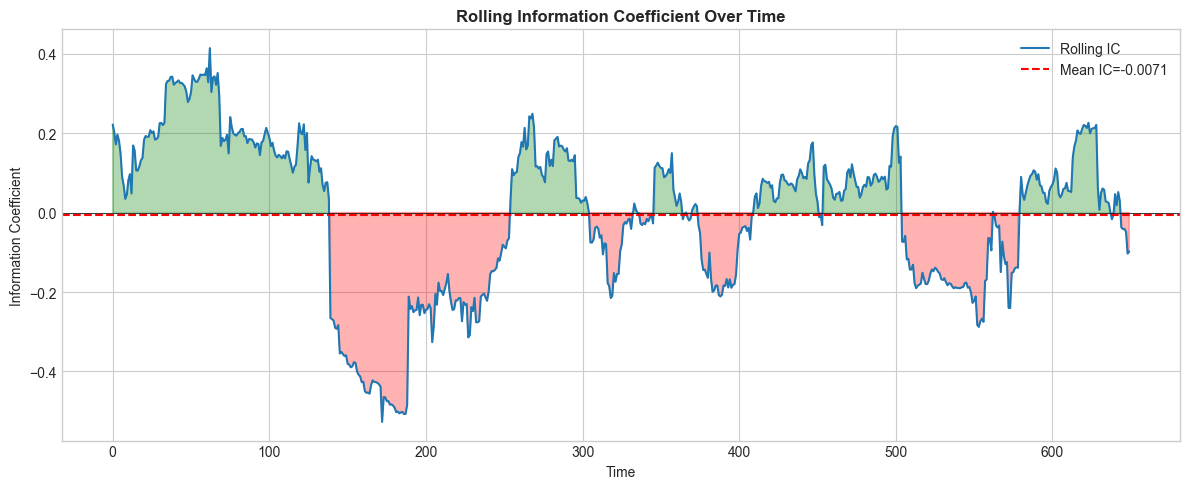

In [8]:
# Rolling out-of-sample test
print("=" * 60)
print("ROLLING OUT-OF-SAMPLE EVALUATION")
print("=" * 60)

def rolling_backtest(X, y, train_window=500, test_window=50):
    """Walk-forward backtest."""
    predictions = []
    actuals = []
    dates = []
    
    scaler = StandardScaler()
    model = Ridge(alpha=1.0)
    
    for i in range(train_window, len(X) - test_window, test_window):
        # Training data
        X_train = X.iloc[i-train_window:i]
        y_train = y.iloc[i-train_window:i]
        
        # Test data
        X_test = X.iloc[i:i+test_window]
        y_test_actual = y.iloc[i:i+test_window]
        
        # Scale and fit
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)
        
        model.fit(X_train_s, y_train)
        y_pred = model.predict(X_test_s)
        
        predictions.extend(y_pred)
        actuals.extend(y_test_actual.values)
        dates.extend(X_test.index)
    
    return np.array(predictions), np.array(actuals), dates

# Run rolling backtest
preds, acts, dates = rolling_backtest(X, y)

# Calculate metrics over time
window = 50
rolling_ic = pd.Series(
    [np.corrcoef(preds[max(0,i-window):i], acts[max(0,i-window):i])[0,1] 
     for i in range(window, len(preds))]
)

print(f"\nOverall Out-of-Sample Metrics:")
print(f"  MSE: {mean_squared_error(acts, preds):.6f}")
print(f"  R²:  {r2_score(acts, preds):.6f}")
print(f"  IC:  {np.corrcoef(preds, acts)[0,1]:.4f}")

print(f"\nRolling IC Statistics:")
print(f"  Mean IC:   {rolling_ic.mean():.4f}")
print(f"  IC Std:    {rolling_ic.std():.4f}")
print(f"  % IC > 0:  {(rolling_ic > 0).mean():.1%}")

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(rolling_ic.values, label='Rolling IC')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axhline(y=rolling_ic.mean(), color='red', linestyle='--', label=f'Mean IC={rolling_ic.mean():.4f}')
ax.fill_between(range(len(rolling_ic)), rolling_ic, 0, 
                where=rolling_ic > 0, alpha=0.3, color='green')
ax.fill_between(range(len(rolling_ic)), rolling_ic, 0, 
                where=rolling_ic <= 0, alpha=0.3, color='red')
ax.set_xlabel('Time')
ax.set_ylabel('Information Coefficient')
ax.set_title('Rolling Information Coefficient Over Time', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

## 📝 Key Takeaways - Day 6

### Regression Metrics Summary:
| Metric | Formula | Use Case |
|--------|---------|----------|
| MSE | $\frac{1}{n}\sum(y-\hat{y})^2$ | Penalizes large errors |
| MAE | $\frac{1}{n}\sum|y-\hat{y}|$ | Robust to outliers |
| R² | $1 - \frac{SS_{res}}{SS_{tot}}$ | Variance explained |
| IC | $corr(\hat{y}, y)$ | Signal strength |

### Classification Metrics:
| Metric | Focus | Trading Use |
|--------|-------|-------------|
| Accuracy | Overall | Not useful alone |
| Precision | False positives | Avoid bad trades |
| Recall | Miss rate | Capture opportunities |
| AUC | Ranking | Model comparison |

### Trading-Specific:
- **Hit Rate**: % of trades profitable
- **Profit Factor**: Gross profit / Gross loss
- **Information Coefficient (IC)**: Correlation between prediction and actual
- **Sharpe Ratio**: Risk-adjusted return

### Interview Questions:
- "What's more important: precision or recall for a long-only strategy?"
- "How would you evaluate a model with high accuracy but low profitability?"
- "Explain the difference between R² and IC"

## 🔴 PROS & CONS: Model Evaluation

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [9]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Model Evaluation Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 14:11

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   GOOGL: $328.38
   GS: $953.01
   JPM: $302.04
   MSFT: $444.11

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🟢 GOOGL: +6.00%
   🟢 GS: +6.01%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   GS: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
